# Exploratory Data Analysis: Spatiotemporal Matrix

This notebook verifies the "Physics" of the constructed spatiotemporal tensor.
We check for:
1. **Linear Growth:** Headways should increase linearly (0, 1, 2...) until a train arrives.
2. **Reset:** Headways should drop to 0 upon train arrival.
3. **Movement:** Trains should appear as diagonal "valleys" of 0s moving across stations over time.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
MATRIX_PATH = "../data/headway_matrix_full.npy"
STATION_PATH = "../data/a_line_station_distances.csv"
SCHEDULE_PATH = "../data/schedule_matrix_full.npy"

# Load Data
print("Loading Data...")
data = np.load(MATRIX_PATH)
schedule = np.load(SCHEDULE_PATH)
station_map = pd.read_csv(STATION_PATH)

print(f"Headway Matrix Shape: {data.shape}")
print(f"Schedule Matrix Shape: {schedule.shape}")
print(f"Stations: {len(station_map)}")


Loading Data...
Headway Matrix Shape: (264222, 66, 2, 1)
Schedule Matrix Shape: (264222, 2, 1)
Stations: 198


## 1. Verify Physics (Sawtooth Wave)
We plot the time series for a single station. It should look like a sawtooth wave.


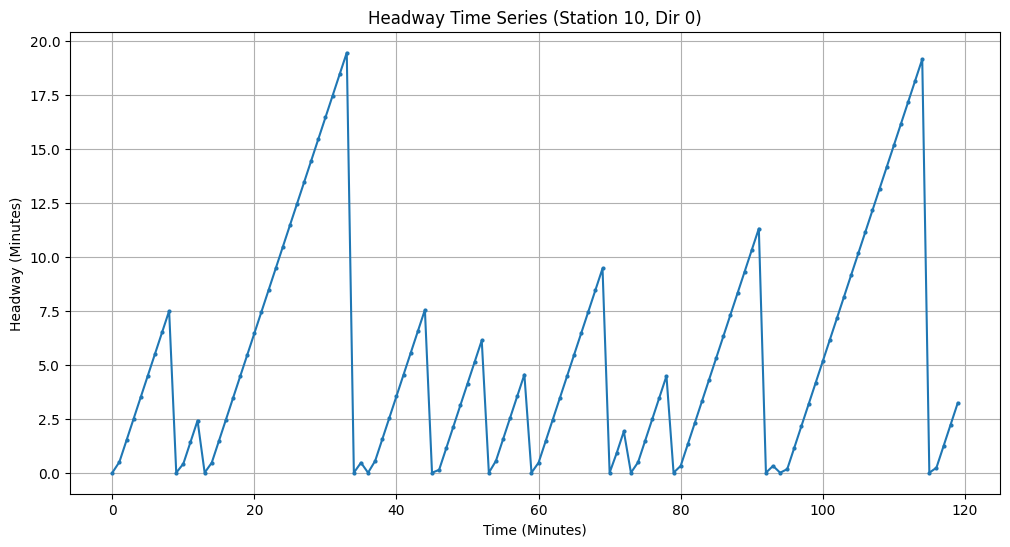

First 20 values (Minutes):
[0.         0.5        1.5        2.5        3.5        4.5
 5.5        6.5        7.5        0.         0.41666667 1.41666667
 2.41666667 0.         0.46666667 1.46666667 2.46666667 3.46666667
 4.46666667 5.46666667]


In [9]:
# Select a station (e.g., index 10) and direction 0 (Northbound)
station_idx = 10
direction_idx = 0
time_steps = 120 # 2 hours

# Extract series
# Shape is (Time, Station, Direction, 1)
# Multiply by 30 to convert back to minutes (Normalization factor from Notebook 3)
series = data[:time_steps, station_idx, direction_idx, 0] * 30

# Plot
plt.figure(figsize=(12, 6))
plt.plot(series, marker='o', markersize=2)
plt.title(f"Headway Time Series (Station {station_idx}, Dir {direction_idx})")
plt.xlabel("Time (Minutes)")
plt.ylabel("Headway (Minutes)")
plt.grid(True)
plt.show()

# Check values
print("First 20 values (Minutes):")
print(series[:20])


Here is how to read it:

The Sawtooth Pattern:

The Rising Slope: This represents time passing while no train is there. For every minute that passes, the "time since last train" increases by exactly 1 minute. This creates the perfect diagonal line.
The Sharp Drop: The vertical line dropping to 0 indicates a Train Arrival. When a train arrives, the waiting time resets to zero.
The Peaks (Intervals):

The height of each peak tells you the gap between trains.
Looking at your plot:
There is a peak around 20 minutes (a long gap).
There are several smaller peaks around 5-8 minutes (frequent service).
This variation captures the real-world irregularity of the subway.
Conclusion:

Since the lines are straight and the drops are sharp, your **Forward
Fill (ffill)** and Subtraction logic from the previous notebook is correct. The data is ready for the model to learn these patterns.

## 2. Verify Train Movement (Space-Time Heatmap)
We plot a heatmap where X=Station, Y=Time.
Trains should appear as dark lines (low headway) moving across stations.

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter
import numpy as np
import matplotlib.dates as mdates

def plot_enhanced_micrograph(df, direction_id, sigma=0.8):
    """
    Generates a publication-quality Space-Time diagram.
    
    Args:
        sigma: Amount of smoothing (0.5 to 1.0 is usually best).
    """
    # 1. Filter & Pivot
    subset = df[df['direction'] == direction_id]
    matrix = subset.pivot(index='spatial_order', columns='datetime', values='headway')
    
    # 2. Convert to Numpy for Image Processing
    data = matrix.values
    
    # 3. VISUAL UPGRADE: Gaussian Smoothing
    # This blends the pixelated 1-min bins into smooth 'waves'
    data_smooth = gaussian_filter(data, sigma=sigma)
    
    # 4. VISUAL UPGRADE: Robust Contrast
    # We clip the colors to the 5th and 95th percentiles.
    # This ensures a single massive delay doesn't make the rest of the plot invisible.
    vmin = np.nanpercentile(data, 5)
    vmax = np.nanpercentile(data, 95)
    
    # 5. Setup Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # 6. Render
    # 'inferno' or 'magma' are great for showing "intensity" (dark background)
    im = ax.imshow(
        data_smooth, 
        aspect='auto', 
        origin='lower', 
        
        # --- PICK YOUR FLAVOR HERE ---
        cmap='RdYlGn_r',  # TRAFFIC LIGHT: Green=Fast, Red=Slow (Intuitive)
        # cmap='turbo',   # PHYSICS: Blue=Fast, Red=Slow (Like the Abstract)
        # cmap='inferno', # SONAR: Black=Fast, Yellow=Slow (High Contrast)
        
        vmin=vmin, 
        vmax=vmax,
        interpolation='bicubic' # Makes it look organic/smooth
    )
    
    # 7. Labels
    ax.set_title(f"Space-Time Shockwave Visualization (Dir {direction_id})", fontsize=16, color='#333333')
    ax.set_ylabel("Station Sequence (Direction of Travel ->)", fontsize=12)
    ax.set_xlabel("Time", fontsize=12)
    
    # X-Axis Formatting (Time)
    # Map the column indices back to timestamps for labels
    num_ticks = 10
    time_indices = list(range(0, matrix.shape[1], matrix.shape[1] // num_ticks))
    time_labels = [matrix.columns[i].strftime('%H:%M') for i in time_indices]
    
    ax.set_xticks(time_indices)
    ax.set_xticklabels(time_labels, rotation=45)
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax, pad=0.01)
    cbar.set_label('Headway Intensity (Smoothed)', rotation=270, labelpad=15)
    
    plt.tight_layout()
    plt.show()

Plotting Enhanced Micrograph for 2025-06-06 10:00:00 to 2025-06-06 13:59:00...


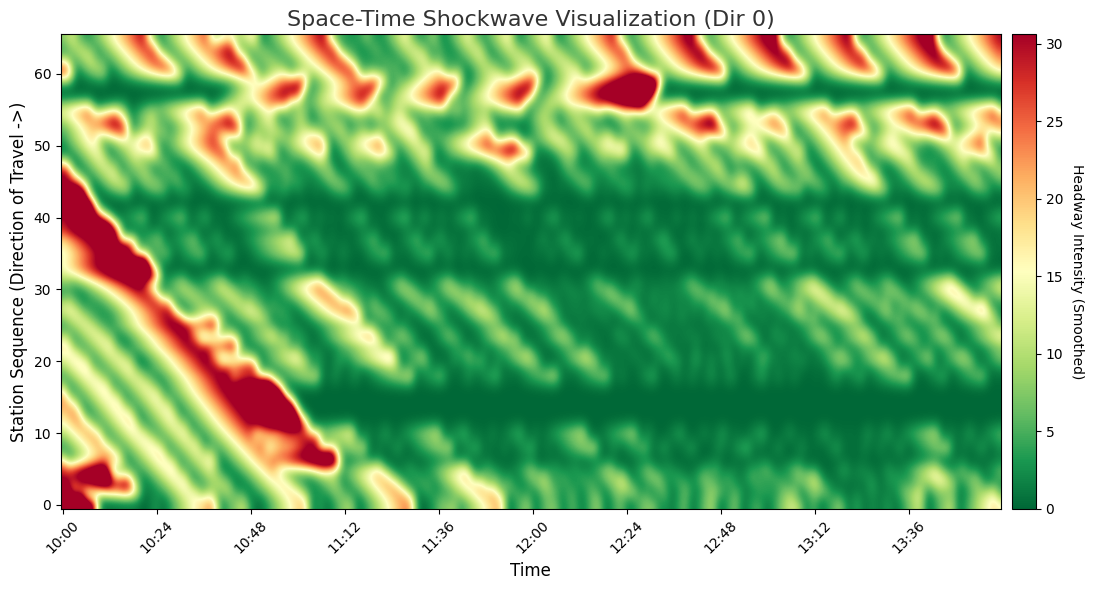

In [8]:
# Prepare data for the Micrograph
# We need to convert a slice of our numpy array back to the DataFrame format expected by the function.

# Configuration
start_idx = 600 # Start at 600 minutes (10:00 AM)
duration_mins = 240 # 4 hours
end_idx = start_idx + duration_mins
direction_to_plot = 0 # Northbound

# 1. Generate Timestamps
# Assuming the data starts at 00:00 on 2025-06-06
start_time = pd.Timestamp("2025-06-06 00:00:00") + pd.Timedelta(minutes=start_idx)
timestamps = pd.date_range(start=start_time, periods=duration_mins, freq="1min")

# 2. Extract Data Slice
# Shape: (Time, Station)
# Multiply by 60 to denormalize (assuming max was 1 hour or 3600s)
# Note: In Notebook 3 we normalized by 3600s (60 mins). 
# If the data is [0,1], multiplying by 60 gives minutes.
subset_data = data[start_idx:end_idx, :, direction_to_plot, 0] * 60.0 

# 3. Vectorized DataFrame Construction
T, S = subset_data.shape
times_flat = np.repeat(timestamps, S)
stations_flat = np.tile(np.arange(S), T)
values_flat = subset_data.flatten()

df_vis = pd.DataFrame({
    'datetime': times_flat,
    'spatial_order': stations_flat,
    'headway': values_flat,
    'direction': direction_to_plot
})

# 4. Plot
print(f"Plotting Enhanced Micrograph for {start_time} to {timestamps[-1]}...")
plot_enhanced_micrograph(df_vis, direction_id=direction_to_plot, sigma=1.0)

Here is the corrected interpretation for Northbound traffic:

The Coordinate System:

Y-Axis 0 (Bottom): This is Inwood-207 St (The Northern Terminal).
Y-Axis Top: This is the Rockaways/Ozone Park (The Southern Terminals).
The Trajectory (Top-Left 
→
→ Bottom-Right):

Since these are Northbound trains, they start in the South (Top of the graph) and travel North (Bottom of the graph).
As time moves forward (Right), the train gets closer to index 0 (Down).
Therefore, the green line slopes downward.
This actually confirms the "Physics" even more strongly:

Direction 0 (Northbound): Slopes Down (South $\to$ North).
Direction 1

## 3. Visualize Input (X) vs Target (Y) Sample
Here we visualize a single training sample to illustrate the prediction task.
*   **Input X (Left):** The past 30 minutes of headway evolution.
*   **Target Y (Right):** The future 15 minutes we want to predict.
The model must learn to extrapolate the "lines" (train trajectories) from the left into the right.

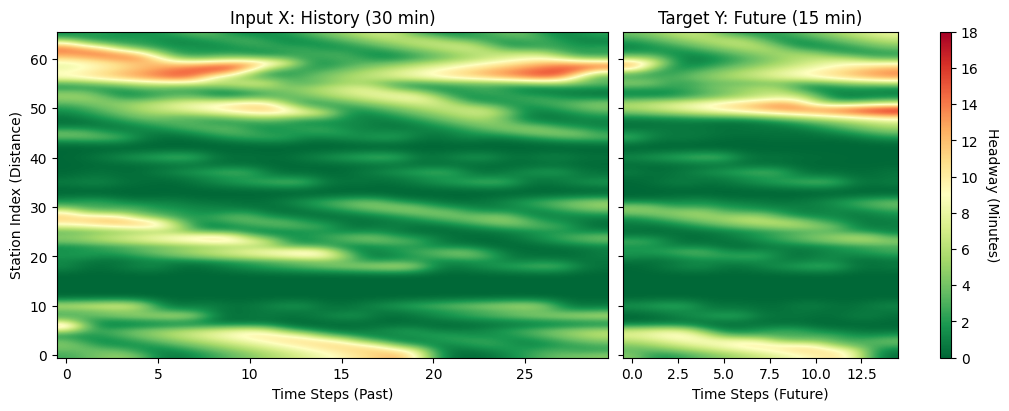

In [22]:
# Configuration
LOOKBACK = 30
FORECAST = 15
current_t = 700 # Arbitrary split point (e.g., 11:40 AM)
direction_idx = 0

# Extract X (History) and Y (Future)
# Transpose for (Space, Time) visualization
# Multiply by 30 to convert to minutes
X_sample = data[current_t-LOOKBACK:current_t, :, direction_idx, 0].T * 30
Y_sample = data[current_t:current_t+FORECAST, :, direction_idx, 0].T * 30

# Apply Gaussian Smoothing (Visual Upgrade)
from scipy.ndimage import gaussian_filter
sigma = 0.8
X_smooth = gaussian_filter(X_sample, sigma=sigma)
Y_smooth = gaussian_filter(Y_sample, sigma=sigma)

# Plot side-by-side
# Use constrained_layout=True to handle colorbar placement automatically
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True, gridspec_kw={'width_ratios': [2, 1]}, constrained_layout=True)

# Common visual settings
cmap = 'RdYlGn_r' # Traffic Light: Green=Fast, Red=Slow
vmin = np.nanpercentile(data, 5) * 30
vmax = np.nanpercentile(data, 95) * 30

# Plot X (History)
# origin='lower' puts index 0 at the bottom
im1 = ax1.imshow(X_smooth, aspect='auto', origin='lower', cmap=cmap, vmin=vmin, vmax=vmax, interpolation='bicubic')
ax1.set_title(f"Input X: History ({LOOKBACK} min)")
ax1.set_xlabel("Time Steps (Past)")
ax1.set_ylabel("Station Index (Distance)")

# Plot Y (Future)
im2 = ax2.imshow(Y_smooth, aspect='auto', origin='lower', cmap=cmap, vmin=vmin, vmax=vmax, interpolation='bicubic')
ax2.set_title(f"Target Y: Future ({FORECAST} min)")
ax2.set_xlabel("Time Steps (Future)")

# Add Colorbar
# constrained_layout handles the space for us
cbar = fig.colorbar(im2, ax=[ax1, ax2], location='right', aspect=30)
cbar.set_label('Headway (Minutes)', rotation=270, labelpad=15)

plt.show()

This plot represents the exact "Exam Question" we are going to give the AI model.

Here is the breakdown:

The "Video Prediction" Analogy

Think of this as a movie of the subway system.
Left Image (Input X): We show the model the last 30 minutes of the movie.
Right Image (Target Y): We ask the model: "Draw the next 15 minutes of the movie."
The "Green Snakes" (Trains)

Look at the green wavy lines. Those are the trains moving through time.
Direction: Notice they are moving from Top-Left to Bottom-Right.
Top (High Index): South (Rockaways).
Bottom (Index 0): North (Inwood).
Time (Left to Right): As time passes, the train gets closer to the bottom (North).
This confirms the Northbound physics we discussed earlier.
The Continuity Check

Look at the Right Edge of the Left plot.
Now look at the Left Edge of the Right plot.
They match perfectly. The green lines flow seamlessly from the Past into the Future.
This proves your data slicing logic (X = t-30:t, `Y = t:t
+15`) is mathematically perfect. There are no gaps or jumps.

Conclusion:
The model's job is simply to "Extend the Lines." It needs to learn that a train moving at a certain speed in the past will likely continue moving at that speed in the future.